## Prerequisites

In [1]:
# Ensure you have `gif` python package installed
!pip install -U gif

Requirement already up-to-date: gif in c:\users\aditya-pc\anaconda3\lib\site-packages (3.0.0)


#### Import utility functions

We have provided a bunch of helper functions in the utils.ipynb notebook that allows for commonly used functions that are not central to the discussion of topic at hand, like plotting functions etc. Feel free to explore the functions and their implementations.

The following cell imports the functions written in the utils notebook. You can ignore this part of the notebook

In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        #print('searching: %s'%nb_path)
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        #print('searching: %s' % nb_path)
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        #print('Found %d cells'%len(nb.cells))
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


#  register the NotebookFinder with sys.meta_path
print('running importer')
sys.meta_path.append(NotebookFinder())

running importer


# Gradient Descent

Gradient descent is a first-order iterative optimization algorithm to find a local minima (or global minima in case of convex function) of a differentiable function. To achieve this, we take steps proportional to the negative of the gradient (or approximate gradient) of the function at the current point.

Conveniently, the objective function of linear regression algorithm is strictly convex and differentiable. Hence, we can use gradient descent optimization to find optimal values of our hypothesis function. 

We revisit the equation to minimize the objective function of linear regression.

\begin{equation}
\min_{\mathbf{w}} \mathbf{J(w)} = \min_{\mathbf{w}} \frac{1}{\mathbf{N}} \sum_\mathbf{i=1}^\mathbf{N} (\mathbf{y_{i} - w^{\top}x_i)^{2}}
\end{equation}

Our gradient descent update for weights is:

\begin{equation}
\mathbf{w^{k+1}} \leftarrow \mathbf{w^k} - \eta \nabla{\mathbf{J}}
\end{equation}

where $\eta$ is our learning rate and,

\begin{equation}
\nabla{\mathbf{J}} = \min_{\mathbf{w}} \frac{2}{\mathbf{N}} \sum_\mathbf{i=1}^\mathbf{N} (\mathbf{y_{i} - w^{\top}x_i)(-x_i)}
\end{equation}

We will look at Standard (Batch) Gradient Descent, Mini-batch, and Stochastic versions of Gradient Descent.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import seaborn as sb; sb.set();
from utils_part2 import plot_convex_loss_and_predict_line, mse_error
import gif

importing Jupyter notebook from utils_part2.ipynb


In [4]:
num_samples = 100
# Generating regression dataset
X_train, Y_train = make_regression(n_samples=num_samples, n_features=1, n_informative=1, noise=20, random_state=2017)

# Adding bias as a column in X
bias_ones = np.ones((num_samples, 1))
X_train = np.hstack((bias_ones, X_train))
Y_train = Y_train.reshape(-1, 1)

In [5]:
print("X_train: num_samples {}, num_features {}" .format((X_train.shape)[0], (X_train.shape)[1]))

X_train: num_samples 100, num_features 2


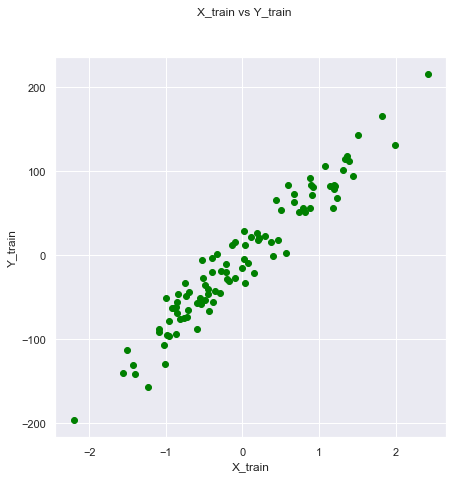

In [6]:
plt.figure(figsize=(7,7));
plt.scatter(X_train[:, 1], Y_train, label='Point', color='green')
plt.suptitle('X_train vs Y_train')
plt.xlabel("X_train")
plt.ylabel("Y_train");

In [7]:
def train(X_train, Y_train, num_epochs, pts_per_batch, learning_rate, gd_type):
    training_errors = []
    frames = []

    # Initializing weights
    w = np.array([-15, 40]) + np.random.rand(2)
    w = w.reshape(-1, 1)

    weights_history = []
    Y_prediction = []
    append_flag = False

    # Getting number of batches/epochs to run
    num_train_datapts = len(Y_train)
    mini_batches = int(num_train_datapts/pts_per_batch)

    # If mini_batches = num_training_datapoints, then standard GD is being executed.
    # If mini_batches > 1 and < num_training_datapoints, and an integer, then mini-batch GD is being run.
    # If mini_batches = 1, then SGD is being run.

    num_batches = int(mini_batches * num_epochs)
    print(f'Num_batches: {num_batches} Mini-batches: {mini_batches} Num_epochs: {num_epochs} Points_per_batch {pts_per_batch} train_point {num_train_datapts}')

    # Do gradient descent for 'num_batches' batches (or mini-batches)
    temp_mse_history = []
    for i in range(1, num_batches+1):

        if num_train_datapts == pts_per_batch:
            # Sampling training data points for batch GD
            X_input = X_train
            Y_true = Y_train
      
        else:
            # Sampling training data points for stochastic or mini-batch GD
            train_idxs = np.random.permutation(num_train_datapts)
            train_idxs = train_idxs[:pts_per_batch]
            X_input = X_train[train_idxs]
            Y_true = Y_train[train_idxs]
      
        y_pred = np.dot(X_input, w)
        # Gradient of l2 loss w.r.t w
        grad_w = -np.dot(X_input.T, Y_true - y_pred)

        temp_mse = np.mean(0.5 * (Y_true - y_pred)**2)
    
        if num_train_datapts == pts_per_batch:
          # Appending values during batch GD
          mse = temp_mse
          append_flag = True
      
        elif pts_per_batch != 1 and pts_per_batch != num_train_datapts:
            temp_mse_history.append(temp_mse)
            if ((i % mini_batches == 0 and mini_batches != 1) or i == 1) and pts_per_batch != 1:
                y_pred = np.dot(X_train, w)
                mse = np.mean(temp_mse_history)
                temp_mse_history = []
                append_flag = True

        elif pts_per_batch == 1:
            y_pred = np.dot(X_train, w)
            mse = np.mean(0.5 * (Y_train - y_pred)**2)
            append_flag = True
     
        # Appending errors, weights, and predictions only if an epoch is completed.
        # This will help us in our visualization of GD.
        if append_flag:
            training_errors.append(mse)
            weights_history.append(w)
            Y_prediction.append(y_pred)
            append_flag = False

        # Update the weights
        w -= (2*learning_rate/pts_per_batch) * grad_w
        w = np.round(w, decimals=2)

    return training_errors, weights_history, Y_prediction

In [8]:
def generate_GD_gifs(training_errors, weights_history, X_train, Y_train, Y_prediction, gd_type='mini-batch'):
    frames = []

    for i in range(len(training_errors)):
        frame = plot_convex_loss_and_predict_line(training_errors, weights_history, X_train, Y_train, Y_prediction, i)
        frames.append(frame)
    gif.save(frames, "content/"+gd_type+"_GD.gif", duration=500)
    print('gifs generated')

Vanilla gradient descent, aka batch gradient descent, calculates the gradient of the loss function w.r.t to the parameters $w$ for all the training examples. We need to only make one update per epoch. However, for a large dataset, batch GD can be slow and sometimes intractable if the datasets don't fit in memory. Also, we can't update our model online, i.e., with new examples on-the-fly. The pseudo code is as follows:

For a dataset $D = (x_i, y_i)_i^m$ of $m$ training examples, 

1.  Initializing weights and biases.
2.  For every epoch $\in [1,...., \text{max_epochs}]$:
     * shuffle D to prevent cycles
     * compute prediction $y_{\text{prediction}} = activation(X_{\text{input}} \times weights)$
     * compute loss $L = (y_{\text{true}}, y_{\text{predicted}})$
     * compute gradients $\Delta \mathbf{w} = - \nabla_{Loss} \mathbf{w}$
     * update parameters $\mathbf{w} :=\mathbf{w}+\Delta \mathbf{w}$

Batch GD is guaranteed to converge to the global minima for convex loss surfaces and to a local minima for non-convex surfaces.

In [9]:
# Batch GD
training_errors, weights_history, Y_prediction = train(X_train, Y_train, num_epochs=20, pts_per_batch=100, learning_rate=0.1, gd_type='batch')

generate_GD_gifs(training_errors, weights_history, X_train, Y_train, Y_prediction, gd_type='batch')

Num_batches: 20 Mini-batches: 1 Num_epochs: 20 Points_per_batch 100 train_point 100
gifs generated


Visualizing Batch Gradient Descent

![Batch GD](https://drive.google.com/uc?id=1OSGBdrmU6a5pCl5f0VOnmon05V2N7Ff1)

In [10]:
# Stochastic GD
training_errors, weights_history, Y_prediction = train(X_train, Y_train, num_epochs=1, pts_per_batch=1, learning_rate=0.1, gd_type='SGD')
generate_GD_gifs(training_errors, weights_history, X_train, Y_train, Y_prediction, gd_type='SGD')

Num_batches: 100 Mini-batches: 100 Num_epochs: 1 Points_per_batch 1 train_point 100
gifs generated


In Stochastic GD, parameter updates are performed for every training example. Due to frequent updates, this leads to high variance that causes the loss function to fluctuate heavily.

These fluctuations can sometimes help to find better local minima. On the other hand, these fluctuations can lead to longer convergence time.

For a dataset $D = (x_i, y_i)_i^m$ of $m$ training examples, 

1.  Initializing weights and biases.
2.  For every epoch $\in [1,...., \text{max_epochs}]$:
>2.1  For iteration $\text{itr} \in [1,....., m]$: 
     * Draw random examples with replacement: $(x_i, y_i) \in D$
     * compute prediction $y_i^{\text{prediction}} = activation(x_i \times weights)$
     * compute loss $L_i = (y_i^{\text{true}}, y_i^{\text{predicted}})$
     * compute gradients $\Delta \mathbf{w} = - \nabla_{Loss_i} \mathbf{w}$
     * update parameters $\mathbf{w} :=\mathbf{w}+\Delta \mathbf{w}$

Visualizing Stochastic Gradient Descent

![SGD](https://drive.google.com/uc?id=1gdelm-z5cjNR1WkdEIiC_VOYCcpbpOlx)

Minibatch GD offers the best of both worlds, i.e., a trade-off between the stochastic GD that perform updates based on a single training example and Batch GD which takes all of the dataset at once. 

In mini-batch, update is performed for every mini-batch of k training examples. Hence, we would have to take more updates per epoch as compared to batch GD.

The updates reduces the variances of parameter updates leading to a more stable convergence. By using highly optimized matrix computation from state-of-the-art machine learning libraries, mini-batch is typically the algorithm of choice when training a neural network.

For a dataset $D = (x_i, y_i)_i^m$ of $m$ training examples,

<ol type="1">
<li>Initializing weights and biases.</li>
<li>For every epoch $\in [1,...., \text{max_epochs}]$:</li>
<ul>
  <li>For iteration $i \in [1,....., n]$: (where n is the mini-batch size)</li>
  <ul>
    <li>Draw random examples with replacement: $(x_i, y_i) \in D$</li>
  </ul>
  <li>compute prediction $y_i^{\text{prediction}} = activation(x_i \times weights)$</li>
  <li>compute loss $L_i = (y_i^{\text{true}}, y_i^{\text{predicted}})$</li>
  <li>compute gradients $\Delta \mathbf{w} = - \nabla_{L_i} \mathbf{w}$</li>
  <li>update parameters $\mathbf{w} :=\mathbf{w}+\Delta \mathbf{w}$</li>
  </ul>
</ol>
  

One can also draw examples without replacement. Drawing examples w/o replacement is more commonly used in modern deep learning libraries. However, we shall look at mini-batch GD where we draw samples at random.

In [11]:
# Mini-batch GD
training_errors, weights_history, Y_prediction = train(X_train, Y_train, num_epochs=20, pts_per_batch=20, learning_rate=0.1, gd_type='mini-batch')
generate_GD_gifs(training_errors, weights_history, X_train, Y_train, Y_prediction, gd_type='mini-batch')

Num_batches: 100 Mini-batches: 5 Num_epochs: 20 Points_per_batch 20 train_point 100
gifs generated


Visualizing mini-batch Gradient Descent

![mini-batch](https://drive.google.com/uc?id=1Lp1tDUS1cid-TUc37zhc5PI9VdYmmzjc)

# Visualizing the effect of learning rate on GD

Now that we have seen the effect of changing the number of batches in a gradient descent, we look at the effect of different learning rates, another important factor that actively influences gradient descent. Previously, we had used 0.1 as our learning rate to train the linear regression model. Let's use Batch gradient descent as an example with lr rate $0.005$ and $1.1. You can try other values for other GD types.

In [12]:
# Batch GD
training_errors, weights_history, Y_prediction = train(X_train, Y_train, num_epochs=20, pts_per_batch=100, learning_rate=0.005, gd_type='batch')
generate_GD_gifs(training_errors, weights_history, X_train, Y_train, Y_prediction, gd_type='batch-small-lr')

Num_batches: 20 Mini-batches: 1 Num_epochs: 20 Points_per_batch 100 train_point 100
gifs generated


![mini-batch-small-lr](https://drive.google.com/uc?id=1gGa7gcwHSCOSUqleCuQKyY1ur1T55W7y)

In [13]:
# Batch GD
training_errors, weights_history, Y_prediction = train(X_train, Y_train, num_epochs=15, pts_per_batch=100, learning_rate=1.1, gd_type='batch')
generate_GD_gifs(training_errors, weights_history, X_train, Y_train, Y_prediction, gd_type='batch-large-lr')

Num_batches: 15 Mini-batches: 1 Num_epochs: 15 Points_per_batch 100 train_point 100
gifs generated


![Batch-large-lr](https://drive.google.com/uc?id=1cMrXF1Edjrg0ZA3oj9YEaRpfntq8_bq9)